# EDA - NoMES


In [1]:
import pandas as pd

changes = pd.read_csv("data_2020.csv", nrows=10000000, sep=';')
changes.head()

,id,bikesAvailable,spacesAvailable,allowDropoff,isFloatingBike,state,realTimeData,time,week,yday,day,month,hour,minute,yhour,year
0,649,3,10,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020
1,529,36,8,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020
2,651,14,11,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020
3,531,2,22,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020
4,532,5,11,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020


In [2]:
# check for missing values (month, days per month)
# lists months and days per month

# expected values = something


def check_missing_values():

    months = changes['month'].unique()

    for m in months:
        print(m)
        month = changes[changes['month'] == m]
        
        print(month['day'].unique())
        
        # compare to expected values
    # return difference


maxspaces = max(changes["bikesAvailable"])

print(changes[changes["bikesAvailable"] == maxspaces])

check_missing_values()

        id  bikesAvailable  spacesAvailable  allowDropoff  isFloatingBike  \
853896  65             119                1             1               0   
854346  65             119                1             1               0   
854796  65             119                1             1               0   

             state  realTimeData                 time  week  yday  day  month  \
853896  Station on             1  2020/08/09 13:40:02    32   222    9      8   
854346  Station on             1  2020/08/09 13:45:01    32   222    9      8   
854796  Station on             1  2020/08/09 13:50:02    32   222    9      8   

        hour       minute  yhour  year  
853896    16  0,666666700   3352  2020  
854346    16  0,750000000   3352  2020  
854796    16  0,833333300   3352  2020  
8
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31]
9
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
10
[ 1  2  3  4

In [3]:
# separate stations in their own dataframes

telling_ids = changes['id'].unique()
stations = {}

for i in telling_ids:
    station = changes[changes['id'] == i]
    stations[i] = station

print(len(stations))
print(stations[11]
)

450
         id  bikesAvailable  spacesAvailable  allowDropoff  isFloatingBike  \
132      11              37                6             1               0   
582      11              37                6             1               0   
1032     11              38                6             1               0   
1482     11              38                6             1               0   
1932     11              38                6             1               0   
...      ..             ...              ...           ...             ...   
9997993  11              33                4             1               0   
9998443  11              33                4             1               0   
9998893  11              33                4             1               0   
9999343  11              34                4             1               0   
9999793  11              34                4             1               0   

              state  realTimeData                 time  wee

In [4]:
# map station names to ids
# clean station names

def clean_names(names):
    # strip and removal of duplicates
    return set([name.strip() for name in names])


station_data = pd.read_csv("tellingit_2017-2021.csv", sep=';')
station_names = station_data[station_data['year'] == 2020]['name'].unique()
station_names = clean_names(station_names)
station_ids = station_data[station_data['year'] == 2020]['id'].unique()

names_ids = {}

for ids in station_ids:
    name = station_data[station_data['id'] == ids].iloc[0]['name']
    names_ids[ids] = name


print(names_ids[11])

Unioninkatu


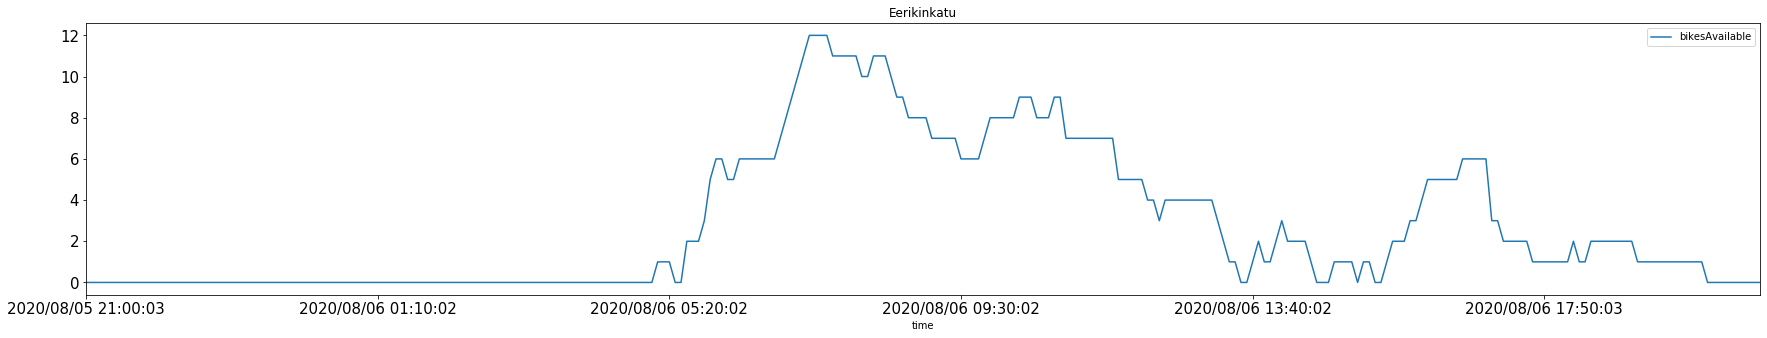

In [5]:
# plot changes per station over time X

import matplotlib.pyplot as plt

def filter_rows(yday: int, station_id: int, min_hour: int, max_hour: int) -> pd.DataFrame():
    yday = yday
    i = station_id
    station = stations[i]

    station = station[station['yday'] == yday]

    if min_hour is not None and max_hour is not None:
        station = station[(station['yhour'] >= min_hour) & (station['yhour'] <= max_hour)]

    return station


def plot_bike_changes(station_id, station):
    title = names_ids[station_id]
    station.plot(x='time', y='bikesAvailable', figsize=(30,5), fontsize=15, title=title)
    plt.savefig(f"img/{title}")

i = 27

station = filter_rows(219, i, None, None)
plot_bike_changes(i, station)


In [6]:
# Primary target: count how many times per day bikes drop to day's minimum

def count_drops(station):
    minbikes = min(station['bikesAvailable'])
    counts = 0
    was_min = False

    for i, row in station.iterrows():
        bikes = row['bikesAvailable'] 

        # drop starts
        if not was_min and bikes == minbikes:
            counts += 1
            was_min = True

        # drop ends
        elif was_min and bikes != minbikes:
            was_min = False

    return counts, minbikes

i = 113
station = filter_rows(219, i, None, None)
print(count_drops(station))
# plot_bike_changes(i, station)

(24, 2)


In [7]:
# Secondary target: Count the number of changes
# there is a change if the number of bikes is different than for the previous 5min (doesn't take into account the number of bikes changed)

def count_changes(station):
    counts = 0
    previous = -1

    for i, row in station.iterrows():
        bikes = row['bikesAvailable'] 

        # print(previous, bikes)
        if bikes != previous:
            # found change 
            counts += 1
            previous = bikes

        # print(counts)
    return counts

i = 11
station = filter_rows(218, i, None, None)
print("changes", count_changes(station))
# plot_bike_changes(i, station)

changes 124


In [8]:
changes = changes.assign(wday=changes['yday'] % 7 + 1)
changes

,id,bikesAvailable,spacesAvailable,allowDropoff,isFloatingBike,state,realTimeData,time,week,yday,day,month,hour,minute,yhour,year,wday
0,649,3,10,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020,7
1,529,36,8,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020,7
2,651,14,11,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020,7
3,531,2,22,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020,7
4,532,5,11,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,709,4,16,1,0,Station on,1,2020/10/23 12:10:02,43,297,23,10,15,"0,166666670",5151,2020,4
9999996,1021,10,10,1,0,Station on,1,2020/10/23 12:10:02,43,297,23,10,15,"0,166666670",5151,2020,4
9999997,1263,23,0,1,0,Station on,1,2020/10/23 12:10:02,43,297,23,10,15,"0,166666670",5151,2020,4
9999998,1141,3,17,1,0,Station on,1,2020/10/23 12:10:02,43,297,23,10,15,"0,166666670",5151,2020,4


In [9]:
# predict number of bikes

import numpy as numpy
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

print('The scikit-learn version is {}.'.format(sklearn.__version__))

station_i = 113
changes = stations[station_i]

X = changes.drop(["bikesAvailable", "state", "time", "minute"], axis=1)
y = changes["bikesAvailable"]

# print(len(X), len(y))

# test_size requires scikit-learn>=0.24.0
tscv = TimeSeriesSplit(n_splits = 5, test_size=288, max_train_size=8064)
# print(tscv)


# scores = cross_val_score(rl, X, y, cv=tscv)
# print(scores)

predictions = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(len(X_train), len(X_test), len(y_train), len(y_test))

    model = LinearRegression()

    rl = model.fit(X_train, y_train)
    score = rl.score(X_test, y_test)
    predicted = rl.predict(X_test)

    predictions.append(predicted)

model = LinearRegression()
scores = cross_val_score(model, X, y, cv=tscv)
print(scores)
predictions_indexed = [pd.Series(prediction, index = y_test.index) for prediction in predictions]

# New data frames from both y_test and predictions
df_y_test = pd.DataFrame(y_test)
df_pred_wide = pd.DataFrame(predictions_indexed)

# Transpose predictions and then add columns 'actual' and 'time' to transposed predictions  
df_pred_long = df_pred_wide.transpose()
df_pred_long['actual'] = df_y_test['bikesAvailable']
df_pred_long['time'] = changes['time']

#df_y_test.to_csv('y_test.csv')
#df_pred_long.to_csv('pred_long.csv')

The scikit-learn version is 1.0.
8064 288 8064 288
8064 288 8064 288
8064 288 8064 288
8064 288 8064 288
8064 288 8064 288
[0.98356562 0.98248669 0.96119827 0.99368382 0.8547578 ]


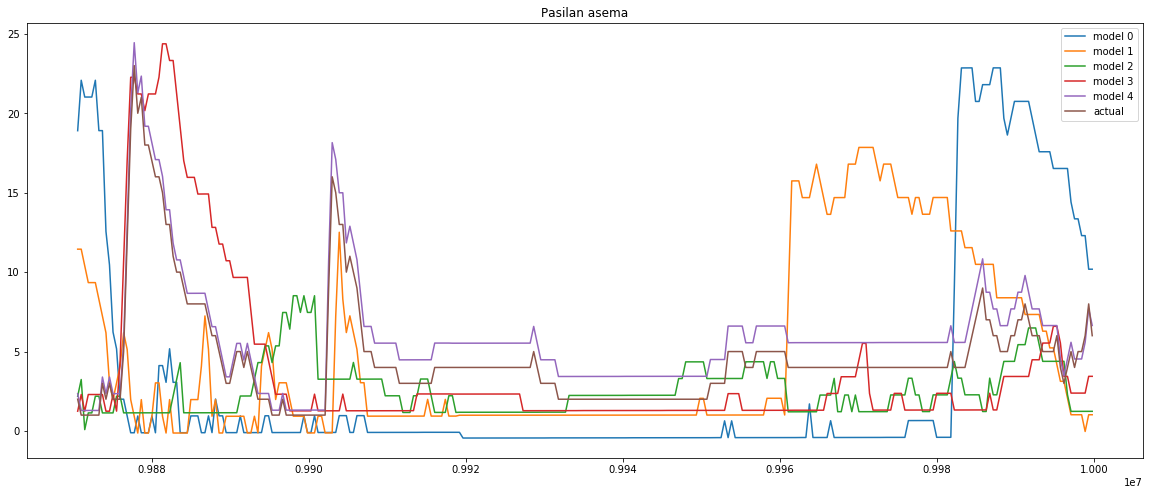

In [10]:
# plot predictions
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,8)

for i, prediction in enumerate(predictions_indexed):
    plt.plot(prediction, label=f"model {i}")

plt.plot(y_test, label="actual")
plt.legend()
plt.title(names_ids[station_i])
plt.show()

Text(0.5, 1.0, 'Pasilan asema')

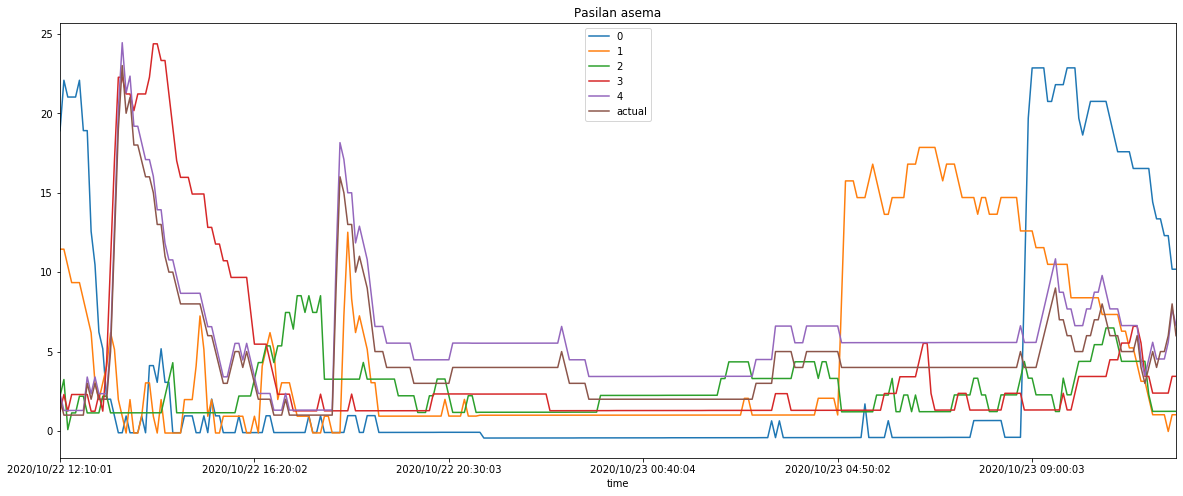

In [11]:
# Plot predictions with timestamp

import matplotlib.pyplot as plt

df_pred_long.plot(x='time')
plt.title(names_ids[station_i])